# Sentiment Analysis Notebook

Sentiment analysis notebook with a simple RNN by Basel.

## 1. Includes

In [14]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re as reg

# NLP refs
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# THE BIG GUNS
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam


# Eval
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report



pd.set_option('display.max_colwidth', 100)
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\basel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\basel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\basel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\basel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Dataset info

In [15]:

splits = {'train': 'train_df.csv', 'validation': 'val_df.csv', 'test': 'test_df.csv'}
df = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + splits["train"])
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Dataset shape: (31232, 4)

First few rows:


,id,text,label,sentiment
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in the widget?,1,neutral
2,17697,"I love the humor, I just reworded it. Like saying 'group therapy' instead`a 'gang banging'. Kee...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative


In [16]:
print("nulls:")
df.isnull().sum()

nulls:


id           0
text         0
label        0
sentiment    0
dtype: int64

In [17]:
print("has links?")
df[df['text'].str.contains('https?')].head()

has links?


,id,text,label,sentiment
21,14653,(bye) plurk out muna. will be back when im done reading the book http://plurk.com/p/rq9c7,1,neutral
24,2900,http://twitpic.com/3ernb - Loving The Jumper,2,positive
54,19253,Download movie 'Ben 10: Alien Force' http://tinyurl.com/czb7b2 cool #movie,2,positive
64,172,URL in previous post (to timer job) should be http://bit.ly/a4Fdb. I`d removed space which messe...,0,negative
102,13643,_nicole http://twitpic.com/4t6qx - i have the exact same pic except it`s my hubby & my chihuahua...,2,positive


In [18]:
print("all english letters?")
df[df['text'].str.contains('[^\x00-\x7F]')].head()

all english letters?


,id,text,label,sentiment
91,6059,"The app is great, and I´ve started to use it rather than wunderlist. Just 3 stars because I don´...",1,neutral
174,8112,"💩👎💩👎💩👎💩 👻☠️ IMPOSSIBLE TO DELETE LIST, OR SUB LISTS (TABS)!!! ☠️👻 REGRET v2.0 UPGRADE!! 👎💩👎💩👎💩👎💩...",0,negative
185,4095,Es muy útil para mantener las aplicaciones del celular cerradas mientras trabajas.,2,positive
241,2091,the app and widɡet are very ɡood. Will change to 5 start when I can be able to add task using go...,1,neutral
414,26054,"ohhhh, how sad...I didnï¿½t get it!",0,negative


## 3. The Prep Kitchen (Preprocessing)

In [19]:
def cleaner(text):
    text = text.lower()
    text = reg.sub(r'<[^>]*>', '',text)
    text = reg.sub(r'http\S+|www\S+|https\S+', '', text)
    text = reg.sub(r'@\w+', '', text)
    text = reg.sub(r'[^a-zA-Z\s]', '', text)
    text = reg.sub(r'\s+', ' ', text).strip()
    return text
df['cleaned_text'] = df['text'].apply(cleaner)
print("Any stragglers?")
df[df['cleaned_text'].str.contains('[^\x00-\x7F]')].head()


Any stragglers?


,id,text,label,sentiment,cleaned_text


In [20]:
def preprocesser(text):
    # tokenize
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # stem
    lemmy = WordNetLemmatizer()
    lemmy_tokens = [lemmy.lemmatize(token) for token in tokens]

    processed_text = ' '.join(lemmy_tokens)

    return processed_text

df['processed_text'] = df['cleaned_text'].apply(preprocesser)
df['processed_text'].head()

0                                                               cooking microwave pizza yummy
1                                                          plan allowing sub task show widget
2    love humor reworded like saying group therapy insteada gang banging keep mom back hahaha
3                                                                           naw idk ur talkin
4                                                                     suck hear hate day like
Name: processed_text, dtype: object

In [ ]:
print("Drop rows where cleanning led to clearing")
df['processed_text'].replace('',np.nan)
df['final_text'] = df['processed_text'].dropna()

empty strings after clean?


''

## 4. Divorcing the dataset (Splitting)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['final_text'], df['label'], test_size=0.2, random_state=42
)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (24985,)
Testing set shape: (6247,)


## 5. CBOWing and stuff (Tokenization/Padding)

In [68]:
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

sequences = tokenizer.texts_to_sequences(X_train)

padded_sequences = pad_sequences(sequences,
                                maxlen=150,
                                padding='post',
                                truncating='post')

print("Original text:", X_train[0])
print("Tokenized sequence:", sequences[0])
print("Shape of padded sequences:", padded_sequences.shape)
print("Example of padded sequence:", padded_sequences[0])

X = padded_sequences
y = df['label']

Original text: cooking microwave pizza yummy
Tokenized sequence: [77, 1, 374, 160, 24, 111, 1]
Shape of padded sequences: (24985, 150)
Example of padded sequence: [ 77   1 374 160  24 111   1   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


## 6. ***IT'S ALIVE*** (Training)

In [83]:
# Params
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
max_length = 150

# The real deal
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(256, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=0.008)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



Y_train_categorical = to_categorical(y_train, num_classes=3)
Y_test_categorical = to_categorical(y_test, num_classes=3)
history = model.fit(
    padded_sequences,
    Y_train_categorical,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)
model.summary()

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - accuracy: 0.4930 - loss: 1.0111 - val_accuracy: 0.6304 - val_loss: 0.8538
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.6187 - loss: 0.8688 - val_accuracy: 0.6448 - val_loss: 0.8234
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.6073 - loss: 0.8796 - val_accuracy: 0.6384 - val_loss: 0.8438
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6178 - loss: 0.8702 - val_accuracy: 0.6292 - val_loss: 0.8464
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.6257 - loss: 0.8591 - val_accuracy: 0.6282 - val_loss: 0.8469
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.5921 - loss: 0.8982 - val_accuracy: 0.6422 - val_loss: 0.8244
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.6044 - loss: 0.8775 - val_accuracy: 0.6286 - val_loss: 0.8415
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.6087 - loss: 0.8700 - val_accurac

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ (None, 150, 300)            │       7,011,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 256)                 │         439,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,402,619 (85.46 MB)

 Trainable params: 7,467,539 (28.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,935,080 (56.97 MB)

## 7. Is he reaally tho? (Eval)

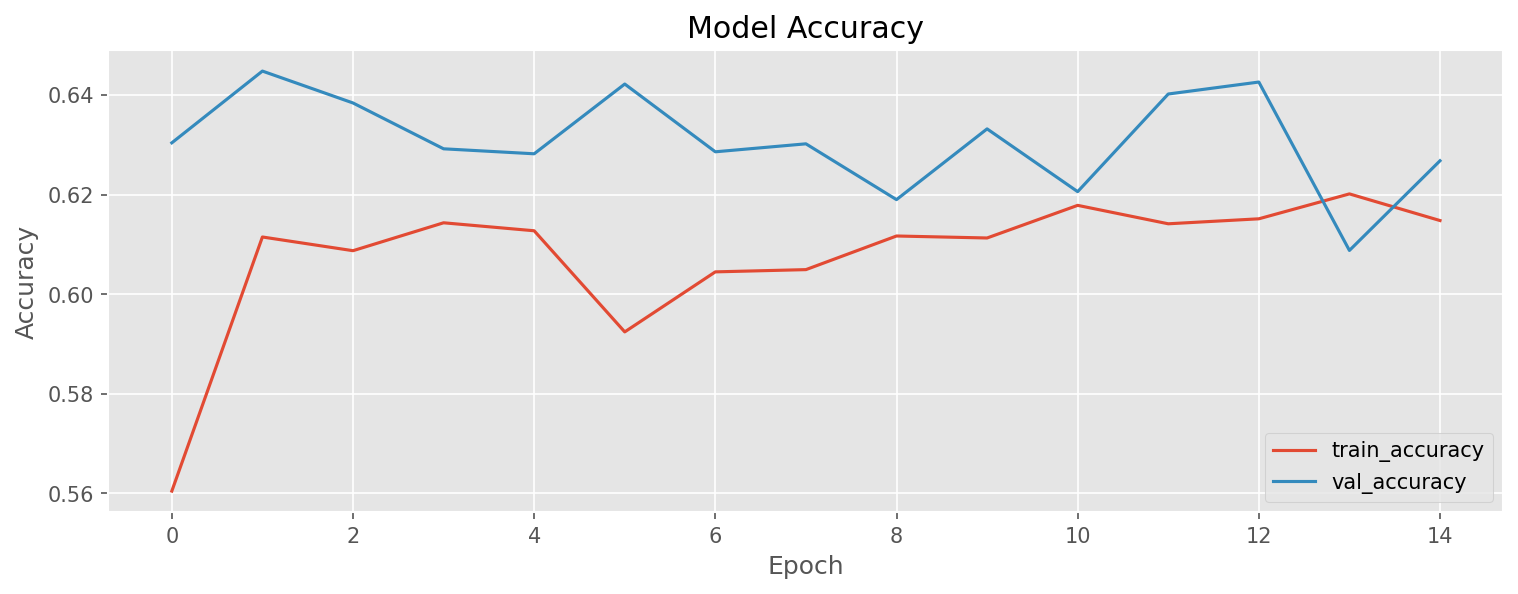

In [84]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [85]:
# Get model predictions (probabilities)
test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
y_probs = model.predict(X_test_padded)
# Print predicted probabilities for the first few negative samples
negative_indices = np.where(y_test == 0)[0]  # Assuming index 0 is 'negative'
print("Negative Sample Probabilities:\n", y_probs[negative_indices[:5]])

# Converting probs into Binary values
y_pred = np.argmax(y_probs, axis=1)

196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Negative Sample Probabilities:
 [[0.27143067 0.48148268 0.24708663]
 [0.2803625  0.46949333 0.25014424]
 [0.05733512 0.16626237 0.7764025 ]
 [0.41860354 0.46088392 0.12051256]
 [0.28537977 0.4807614  0.23385878]]


In [86]:
# Evaluate the model\

loss, accuracy = model.evaluate(X_test_padded, Y_test_categorical)
print(f"Loss: {loss}, Accuracy: {accuracy}")

196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6137 - loss: 0.8511
Loss: 0.8564510345458984, Accuracy: 0.6138946413993835


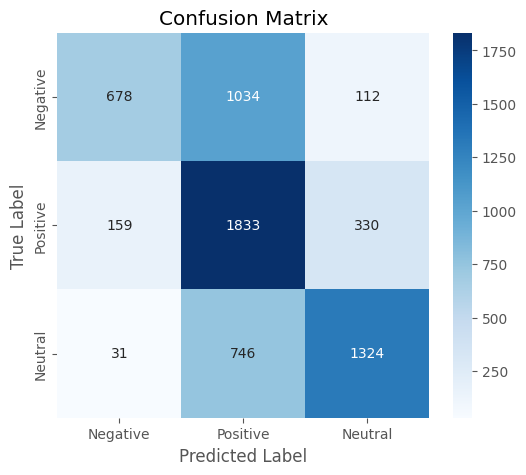

In [87]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(np.argmax(Y_test_categorical, axis=1),y_pred ), annot=True, fmt="d", cmap="Blues", xticklabels=['Negative' , 'Positive' , 'Neutral'], yticklabels=['Negative' , 'Positive','Neutral'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()